# Practice: Handling Missing Data
Aug 19, 2019<br>
Ngoc Tran<br>
(Inspired by: https://www.kaggle.com/dansbecker/handling-missing-values)

------------------------------------

## Import

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from pathlib import Path
# from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Change directory to get change directory source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

## Load data

Change directory to get data:

In [5]:
cd = change_directory.ChangeDirectory()

In [6]:
cd.change_to_data_dir()

Load data:

In [7]:
ih_1 = pd.read_csv("Iowa_Housing_1.csv")
ih_2 = pd.read_csv("Iowa_Housing_2.csv")
ih = pd.concat([ih_1, ih_2]).reset_index(drop=True)

Change back to notebook directory:

In [8]:
cd.change_to_notebook_dir()

## Explore data

Quick look:

In [9]:
ih.shape

(2919, 81)

In [10]:
ih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2454 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

For the sake of simplicity, we use only numeric predictors.

In [11]:
ih = ih.select_dtypes(exclude=["object"])

In [12]:
ih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 38 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
LotFrontage      2454 non-null float64
LotArea          2919 non-null int64
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
MasVnrArea       2896 non-null float64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtUnfSF        2918 non-null float64
TotalBsmtSF      2918 non-null float64
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
LowQualFinSF     2919 non-null int64
GrLivArea        2919 non-null int64
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
FullBath         2919 non-null int64
HalfBath         2919 non-null int64
BedroomAbvGr     2919 non-null int64
KitchenAbvGr     2919 non-null int64
TotRmsAbvGrd     2919 non-

In [13]:
ih.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


Duplicates?

In [14]:
len(ih[ih.duplicated()])

0

How many rows have missing values per column?

In [15]:
ih.isna().sum().sort_values(ascending=False)

LotFrontage      465
GarageYrBlt      159
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageArea         1
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
LotArea            0
GrLivArea          0
MSSubClass         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
SalePrice          0
YrSold             0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
Id                 0
dtype: int64

We don't need the Id column.

In [16]:
ih.drop(["Id"], axis=1, inplace=True)

Let's set 500 rows (with no missing values) aside for our test set.

In [17]:
rows_no_missing_values = ih[~ih.isna().any(axis=1)].reset_index(drop=True)

In [18]:
rows_no_missing_values_randomized = rows_no_missing_values.sample(len(rows_no_missing_values),
                                                                  random_state=123)

In [19]:
test = rows_no_missing_values_randomized[:500].reset_index(drop=True)

Our training set includes all of the other rows.

In [20]:
rows_missing_values = ih[ih.isna().any(axis=1)].reset_index(drop=True)

In [21]:
training = pd.concat([rows_missing_values, rows_no_missing_values_randomized[500:]]).reset_index(drop=True)

Which columns have missing values?

In [22]:
cols_with_missing = list(training.columns[training.isna().any()])
print(len(cols_with_missing))
print(cols_with_missing)

11
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


### LotFrontage

In [23]:
ih.LotFrontage.describe()

count    2454.000000
mean       68.712714
std        24.105764
min         0.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

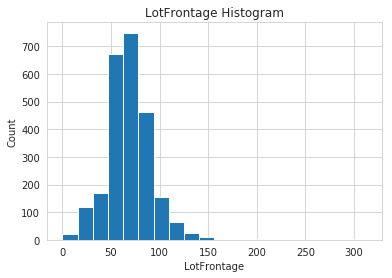

In [24]:
ih.LotFrontage.hist(bins=20);
plt.title("LotFrontage Histogram");
plt.xlabel("LotFrontage");
plt.ylabel("Count");

Median $\approx$ mean.

### MasVnrArea

In [25]:
ih.MasVnrArea.describe()

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

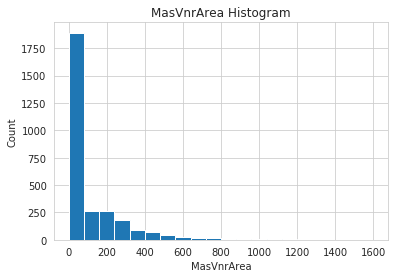

In [26]:
ih.MasVnrArea.hist(bins=20);
plt.title("MasVnrArea Histogram");
plt.xlabel("MasVnrArea");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtFinSF1

In [27]:
ih.BsmtFinSF1.describe()

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

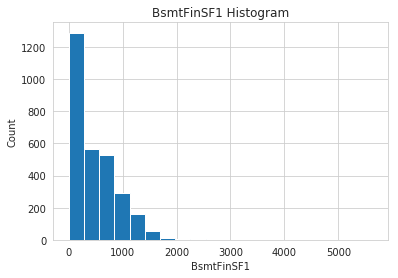

In [28]:
ih.BsmtFinSF1.hist(bins=20);
plt.title("BsmtFinSF1 Histogram");
plt.xlabel("BsmtFinSF1");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtFinSF2

In [29]:
ih.BsmtFinSF2.describe()

count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64

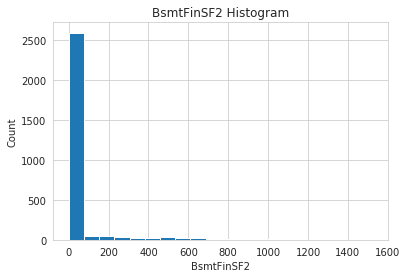

In [30]:
ih.BsmtFinSF2.hist(bins=20);
plt.title("BsmtFinSF2 Histogram");
plt.xlabel("BsmtFinSF2");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtUnfSF

In [31]:
ih.BsmtUnfSF.describe()

count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
25%       220.000000
50%       467.000000
75%       805.500000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

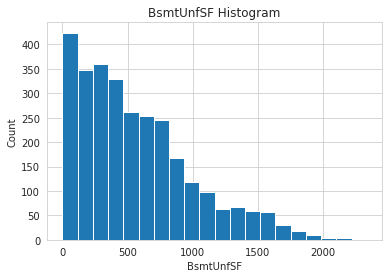

In [32]:
ih.BsmtUnfSF.hist(bins=20);
plt.title("BsmtUnfSF Histogram");
plt.xlabel("BsmtUnfSF");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### TotalBsmtSF

In [33]:
ih.TotalBsmtSF.describe()

count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

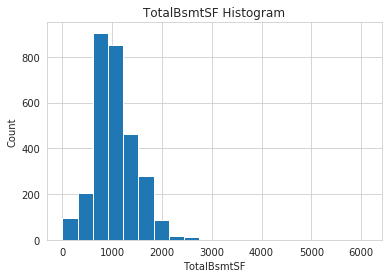

In [34]:
ih.TotalBsmtSF.hist(bins=20);
plt.title("TotalBsmtSF Histogram");
plt.xlabel("TotalBsmtSF");
plt.ylabel("Count");

Median $\approx$ mean.

### BsmtFullBath

In [35]:
ih.BsmtFullBath.describe()

count    2917.000000
mean        0.429894
std         0.524736
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

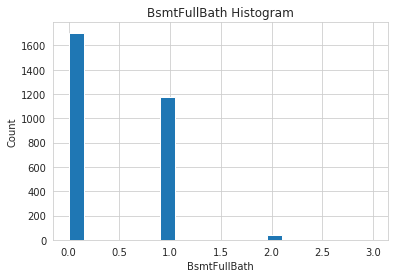

In [36]:
ih.BsmtFullBath.hist(bins=20);
plt.title("BsmtFullBath Histogram");
plt.xlabel("BsmtFullBath");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtHalfBath

In [37]:
ih.BsmtHalfBath.describe()

count    2917.000000
mean        0.061364
std         0.245687
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

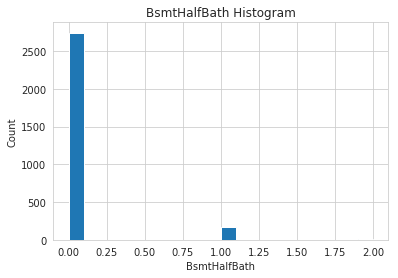

In [38]:
ih.BsmtHalfBath.hist(bins=20);
plt.title("BsmtHalfBath Histogram");
plt.xlabel("BsmtHalfBath");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### GarageYrBlt

In [39]:
ih.GarageYrBlt.describe()

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

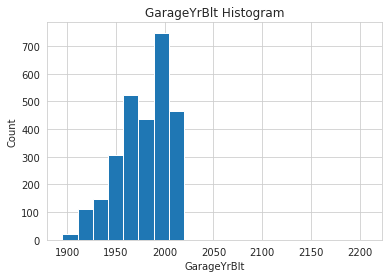

In [40]:
ih.GarageYrBlt.hist(bins=20);
plt.title("GarageYrBlt Histogram");
plt.xlabel("GarageYrBlt");
plt.ylabel("Count");

Median $\approx$ mean.

### GarageCars

In [41]:
ih.GarageCars.describe()

count    2918.000000
mean        1.766621
std         0.761624
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64

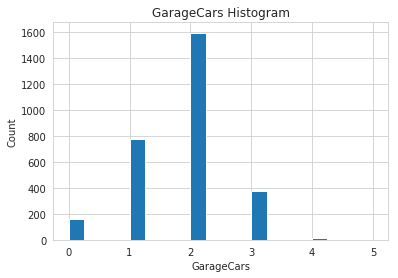

In [42]:
ih.GarageCars.hist(bins=20);
plt.title("GarageCars Histogram");
plt.xlabel("GarageCars");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### GarageArea

In [43]:
ih.GarageArea.describe()

count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
25%       320.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64

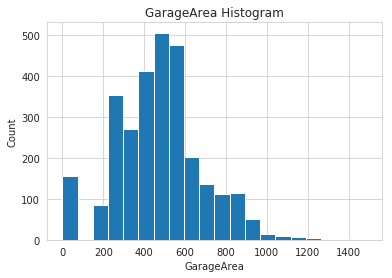

In [44]:
ih.GarageArea.hist(bins=20);
plt.title("GarageArea Histogram");
plt.xlabel("GarageArea");
plt.ylabel("Count");

Median $\approx$ mean.

## Techniques to treat missing values:

Change directory to get model performance source code:

In [45]:
cd.change_to_src_models_dir()

More import:

In [46]:
from model_performance import mean_abs_error

Change back to notebook directory:

In [47]:
cd.change_to_notebook_dir()

### Drop Rows with Missing Values

In [48]:
training_drop_rows = training.copy()
test_drop_rows = test.copy()

In [49]:
training_drop_rows = training_drop_rows[~training_drop_rows.isna().any(axis=1)].reset_index(drop=True)

In [50]:
training_drop_rows_X = training_drop_rows.drop(["SalePrice"], axis=1)
training_drop_rows_y = training_drop_rows.SalePrice
test_drop_rows_X = test_drop_rows.drop(["SalePrice"], axis=1)
test_drop_rows_y = test_drop_rows.SalePrice

In [51]:
print("Mean Absolute Error from dropping rows with missing values:")
mae_drop_rows = mean_abs_error(training_drop_rows_X, test_drop_rows_X, training_drop_rows_y, test_drop_rows_y)
print(mae_drop_rows)

Mean Absolute Error from dropping rows with missing values:
30392.745303630003


In [52]:
# 30392.745303630003

### Drop Columns with Missing Values

In [53]:
training_drop_cols = training.copy()
test_drop_cols = test.copy()

In [54]:
training_drop_cols_X = training_drop_cols.drop(["SalePrice"], axis=1)
training_drop_cols_X = training_drop_cols.drop(cols_with_missing, axis=1)
training_drop_cols_y = training_drop_cols.SalePrice
test_drop_cols_X = test_drop_cols.drop(["SalePrice"], axis=1)
test_drop_cols_X = test_drop_cols.drop(cols_with_missing, axis=1)
test_drop_cols_y = test_drop_cols.SalePrice

In [55]:
print("Mean Absolute Error from dropping columns with missing values:")
mae_drop_cols = mean_abs_error(training_drop_cols_X, test_drop_cols_X, training_drop_cols_y, test_drop_cols_y)
print(mae_drop_cols)

Mean Absolute Error from dropping columns with missing values:
308.55533303999937


In [56]:
# 308.55533303999937

### Imputation (Averaging Techniques)

### An Extension To Imputation (Averaging Techniques)

### Imputation (Predictive Techniques)

### An Extension To Imputation (Predictive Techniques)